In [1]:
""" 
File to import and implement ARIMA models and different types of smoothing and lagging
"""

' \nFile to import and implement ARIMA models and different types of smoothing and lagging\n'

In [102]:
# Imports 
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [103]:
# Load data
df_prod = pd.read_csv("production_100_data.csv")
df_cons = pd.read_csv("consumption_100_data.csv")

df_prod_2_year_cons = pd.read_csv('year_coverage_consumption_100.csv')
df_prod_2_year_prod = pd.read_csv('year_coverage_production_100.csv')

df_prod_2_year_prod = df_prod_2_year_prod[df_prod_2_year_prod["time_between_first_last"] >= 2]
df_prod_2_year_cons = df_prod_2_year_cons[df_prod_2_year_cons["time_between_first_last"] >= 2]

# Sort by time_between_first_last
df_prod_2_year_cons = df_prod_2_year_cons.sort_values(by=['time_between_first_last'], ascending=False)
df_prod_2_year_prod = df_prod_2_year_prod.sort_values(by=['time_between_first_last'], ascending=False)

In [104]:
print(df_prod_2_year_prod[["meter_id", "time_between_first_last"]].head())

                                 meter_id  time_between_first_last
93   28ba7f57-6e83-4341-8078-232c1639e4e3                 2.690297
71   e3c18c2d-30f1-432e-bbfa-ee5d0117987e                 2.553311
151  60ad4a18-0ca3-48e4-8289-a2a0ee15c3bd                 2.512100
112  81c2f221-3be4-4f07-aec2-88f135fd7869                 2.512100
92   29964561-4c45-4dbb-bc91-4a4e35fa9d67                 2.512100


In [105]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        df_return = df_return.drop(["meter_id"], axis=1)
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"])
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_prod["meter_id"] == meter_id]
        df_return = df_return.drop(["meter_id"], axis=1)
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"])
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

In [111]:
# Cut data to only use the first year
series = get_series("28ba7f57-6e83-4341-8078-232c1639e4e3",
                        type="cons",
                        start=None,
                        end=None,
                        agg="day")
# print nan
print(series)

Getting series for meter_id: 28ba7f57-6e83-4341-8078-232c1639e4e3
                           num_kwh
timeslot                          
2017-08-12 00:00:00+00:00    0.000
2017-08-13 00:00:00+00:00    7.000
2017-08-14 00:00:00+00:00    7.000
2017-08-15 00:00:00+00:00   11.000
2017-08-16 00:00:00+00:00    8.000
...                            ...
2019-05-10 00:00:00+00:00   32.616
2019-05-11 00:00:00+00:00   28.099
2019-05-12 00:00:00+00:00   31.069
2019-05-13 00:00:00+00:00   29.367
2019-05-14 00:00:00+00:00   20.056

[641 rows x 1 columns]


/var/folders/b1/gpnk8rp50gd31snzzh0dyycr0000gn/T/ipykernel_55469/4184184614.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_return = df_cons[df_prod["meter_id"] == meter_id]


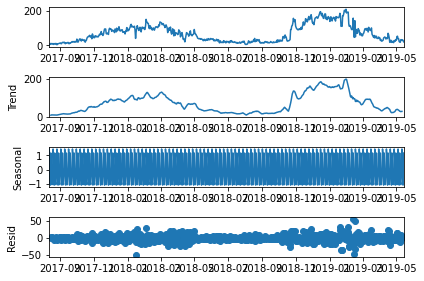

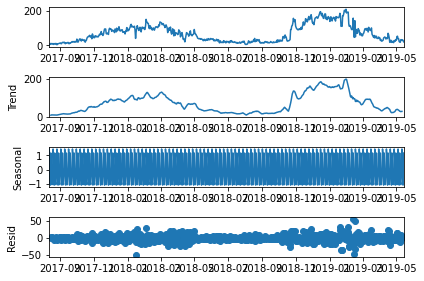

In [114]:
# Fit Seasonal Decomposition
decomp = seasonal_decompose(series, model="additive")
decomp.plot()

In [115]:
# Define a baseline function
def baseline_model(series, days_to_forecast):
    """Create baseline from series

    Args:
        series (pd.Series): series to create baseline from
        days_to_forecast (int): days to forecast

    Returns:
        pd.Series: Baseline forecast
    """
    # For each day to forecast, get the value from the last week
    # Create series with index same as series
    baseline = pd.Series(index=series.index[-days_to_forecast:])
    # For each day to forecast
    for i in range(days_to_forecast):
        # Get the last week
        last_week = series.iloc[-i-7]
        # Add to baseline
        baseline[i] = last_week

    
    # Return forecast
    return baseline


/var/folders/b1/gpnk8rp50gd31snzzh0dyycr0000gn/T/ipykernel_55469/2266444598.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  baseline = pd.Series(index=series.index[-days_to_forecast:])


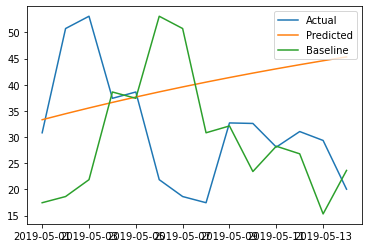

In [116]:
# Fit model
days_to_forecast = 14

prod_arima = ARIMA(series[:-days_to_forecast], order=(1,0,0))
prod_arima_fit = prod_arima.fit()
# print(prod_arima_fit.summary())
# Forecast

arima_forecast = prod_arima_fit.forecast(steps=days_to_forecast)
# print("ARIMA Forecast")
# print(forecast)

actual = series[-days_to_forecast:]
# print("Actual Values")
# print(actual)

baseline_forecast = baseline_model(series, days_to_forecast)

# plot the error between the actual and predicted values
plt.plot(actual, label="Actual")
plt.plot(arima_forecast, label="Predicted")
plt.plot(baseline_forecast, label="Baseline")
plt.legend()
plt.show()

